<a href="https://colab.research.google.com/github/zar55/COSC_635_Reinforcement_Learning/blob/main/Lab_08_zziauddin1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COSC-635: Lab 8

**Zargham Ziauddin**


## Getting Started

Follow the instructions below to copy this notebook and to perform some initial setup.

1. Copy this notebook by selecting `File > Save a copy in Drive`.
2. A new window should open for the copied notebook. Move the new notebook to your course folder in Google Drive by selecting `File > Move` and then selecting the desired folder.
3. Update the name of the notebook by removing "Copy of" and replacing "Username" with your actual username.
4. Update the first cell in the notebook by specifying your course number (435 or 635) and by replacing "Student Name" with your actual name.
5. Mount your Google Drive by running the cell below and accepting the prompts you are presented with.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the Colab Environment

Run the cell below to install gymnasium and to download rltools to the virtual machine.

In [ ]:
%%capture
!pip install swig
!pip install gymnasium[box2d]==0.28.1
!pip install "stable-baselines3[extra]==2.0.0"
!rm rltools -r
!git clone https://github.com/drbeane/rltools.git
!git clone https://github.com/drbeane/rl_models.git

The cell below includes the import statements that you will need for this assignmnet.

In [ ]:
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from rltools.utils import RandomAgent, SB3Agent
from rltools.utils import create_gif, evaluate, sb3_evaluation_curves

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

import warnings
warnings.filterwarnings('ignore')

## Note on Variable Names

You are free to select the variable names for the objects that you create in this notebook. But please make sure that the variable names you select in Part 1 are distinct from those used in Part 2. An exception to this rule can be made in instances where a particular variable will be used in a single cell, but no where else in the notebook.

## GPU Acceleration

GPU acceleration will be helpful for some parts of this assignment. Specifically, the code in 2.C will run significantly faster on a GPU than on a CPU. The rest of the notebook, however, can be run on CPU with no issues.

Google Colab provides free GPU access, but this usage is subject to a daily limit. In order to preserve your GPU hours, I would recommend not enabling the GPU until you are ready to run code in 2.C.

The GPU can be enabled by going to `Runtime > Change runtime type`. You should have `T4 GPU` selected.

Keep in mind that changing the runtime type does reset your kernal, so you will need to re-run the cells at the start of the notebok after enabling the GPU.

# Part 1 - Exploring Breakout Environment

In Part 1 of this assignment, you will be exploring the Atari Breakout environment. We will train a PPO agent on this environment in Part 2.

You can find information about the Breakout environment in the Gymnasium documentation: [Gymnasium Documentation: Breakout](https://gymnasium.farama.org/environments/atari/breakout/)

## 1.A - Create Environment

Use the cell below to create an instance of the environment. Use the `BreakoutNoFrameskip-v4` version of the environment. This should be a standard, unprocessed version of the environment created with `gym.make()`. Display a render the starting state of the environment (without showing the axes).

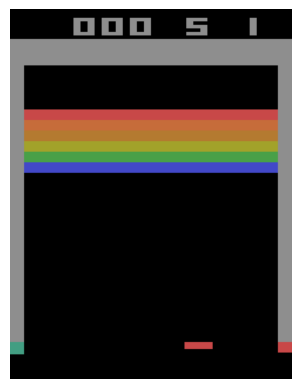

In [ ]:
breakout = gym.make('BreakoutNoFrameskip-v4', render_mode = 'rgb_array')

state, info = breakout.reset()

plt.imshow(breakout.render())
plt.axis('off')
plt.show()

## 1.B - Action and Observation Space

Print the `shape` attribute of the environment's `observation_space` to determine the size of the state arrays. Then print the `n` attribute of the environment's `action_space` to determine the number of actions available.


In [ ]:
breakout_observation = breakout.observation_space.shape

breakout_action = breakout.action_space.n

print(f"Observation Space Shape: {breakout_observation} \nAction Space Shape: {breakout_action}")

Observation Space Shape: (210, 160, 3) 
Action Space Shape: 4


## 1.C - Performance of Random Agent

Use the cell below to create an instance of `RandomAgent` for this environment. Then use `evaluate()` to analyze the agent's performance. Use `gamma=1.0`, `episodes=50`, `max_steps=2000`, and `seed=1`.

In [ ]:
breakout_random = RandomAgent(breakout)

breakout_eval = evaluate(breakout,
                         breakout_random,
                         gamma = 1.0,
                         episodes = 50,
                         max_steps = 2_000,
                         seed = 1)

Mean Return:    1.2
StdDev Return:  1.3115
Mean Length:    682.1
StdDev Length:  211.2406


## 1.D - Sample Episode For Random Agent

Use the cell below to create a gifs demonstrating an episode generated by the random agent. Set `max_steps=2000`, `seed=1`, and `scale=1.5` when calling `create_gif()`.

615 steps completed.
Cumulative reward: 1.0


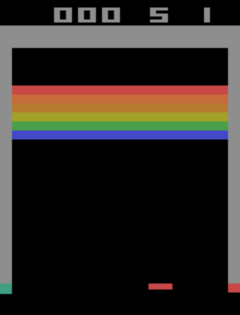

In [ ]:
create_gif(breakout,
           breakout_random,
           max_steps = 2_000,
           seed = 1,
           scale = 1.5,
           folder = 'gifs',
           filename = 'breakout')

# Part 2 - Training a PPO Agent

In Part 2 of this assignment, you will train a PPO agent on the Breakout environment. Our goals for this agent will be modest. While it is possible to train a PPO agent that performs very well on this environment, it does take a long time to do so. Our goal will be to train an agent that demonstates some amount of ability to react to the ball, even if it does not achieve a high score.

## 2.A - Create Environments

Use the cell below to create environments for training, evaluation, and testing. Instructions for creating the environments are provided below.

* Use `make_atari_env()` to create three vectorized, processed instances of the breakout environment.
    * Use `n_envs=8` for the training and evaluation environments and `n_envs=1` for the testing environment.
    * Set `seed=0` in each case.
    * Set `wrapper_kwargs={'clip_reward':False}` in the calls to `make_atari_env()` for the training and evaluation environments. This tells the environment to use the reward structure from the original game rather than clipping all rewards to 1.
    * Set `wrapper_kwargs={'clip_reward':False, 'terminal_on_life_loss':False}` in the calls to `make_atari_env()` for the test environments. Setting `terminal_on_life_loss` to `False` tells the environment to not terminate when the first life is lost.

* Use `VecFrameStack()` to create framestacked versions of each of the three environments. In each case, set `n_stack=4`.

When you are done creating the environments, print the `shape` attribute of the framestacked test environment's `observation_space` attribute.

In [ ]:
breakout_train_env = make_atari_env(env_id = 'BreakoutNoFrameskip-v4',
                                    n_envs = 8,
                                    seed = 0,
                                    wrapper_kwargs = {'clip_reward':False}
                                    )
breakout_train_vec_env = VecFrameStack(breakout_train_env, n_stack = 4)



breakout_eval_env = make_atari_env(env_id = 'BreakoutNoFrameskip-v4',
                                   n_envs = 8,
                                   seed = 0,
                                   wrapper_kwargs = {'clip_reward':False}
                                   )
breakout_eval_vec_env = VecFrameStack(breakout_eval_env, n_stack = 4)


breakout_test_env = make_atari_env(env_id = 'BreakoutNoFrameskip-v4',
                                   n_envs = 1,
                                   seed = 0,
                                   wrapper_kwargs = {'clip_reward':False, 'terminal_on_life_loss':False}
                                   )
breakout_test_vec_env = VecFrameStack(breakout_test_env, n_stack = 4)

print(f"Observation Space Shape: {breakout_test_vec_env.observation_space.shape} \nAction Space Shape: {breakout_test_vec_env.action_space.n}")

Observation Space Shape: (84, 84, 4) 
Action Space Shape: 4


## 2.B - Create Evaluation Callback

In the cell below, create an `EvalCallback` object using the framestacked evaluation environment. Set the callback to run the evalation every 1000 time steps, using 10 episodes for each evaluation. Set `warn=False`.

In [ ]:
if os.path.exists('breakout_evaluation/') : shutil.rmtree('breakout_evaluation/')
breakout_callback = EvalCallback(breakout_eval_vec_env,
                                 best_model_save_path = 'breakout_evaluation/',
                                 log_path = 'breakout_evaluation/',
                                 eval_freq = 1_000,
                                 n_eval_episodes = 10,
                                 warn = False
                                 )

## 2.C - Build and Train Model

The cell below provides code for creating a linear scheduler for the learning rate, as well as code for building and training a PPO model. Complete the code by providing your framestacked training environment and your evaluation callback. It will likely take around 15-20 minutes for this cell to run.

**Extra Credit Opportunity:** The parameters supplied below should produce an agent that does not play particular well, but that demonstates some ability to play. When evaluating this agent in 2.E below, we should see that it obtains a mean score of around 20. You are encouraged to experiment with the parameters to see if you can get better performance. If you are able to meet certain performance objectives, you can earn extra credit on this assignment. This will be discussed further after Part 2.E below.

If attempting to obtain a better score, you can adjust any of the parameters below. The most important parameters to adjust might be the total number of timesteps, the learning rate, and the clip range.

In [ ]:
%%time

def linear_schedule(initial_lr, final_lr):
    def sched_func(progress_remaining):
        return final_lr + progress_remaining * (initial_lr - final_lr)
    return sched_func

model = PPO(
    env = breakout_train_vec_env,
    policy = "CnnPolicy",
    n_steps = 128,
    n_epochs = 4,
    batch_size = 256,
    learning_rate = linear_schedule(1e-3, 0),
    clip_range = 0.2,
    vf_coef = 0.5,
    ent_coef = 0.01,

    verbose=0,
    seed=1,
)

model = model.learn(total_timesteps=300_000, progress_bar=False, callback=breakout_callback)

Eval num_timesteps=8000, episode_reward=5.40 +/- 4.41
Episode length: 1191.70 +/- 538.50
New best mean reward!
Eval num_timesteps=16000, episode_reward=2.80 +/- 0.87
Episode length: 961.70 +/- 172.75
Eval num_timesteps=24000, episode_reward=6.10 +/- 2.12
Episode length: 1282.00 +/- 192.04
New best mean reward!
Eval num_timesteps=32000, episode_reward=3.60 +/- 3.01
Episode length: 955.70 +/- 303.25
Eval num_timesteps=40000, episode_reward=11.00 +/- 3.95
Episode length: 12376.80 +/- 31875.26
New best mean reward!
Eval num_timesteps=48000, episode_reward=8.10 +/- 4.39
Episode length: 1577.70 +/- 453.26
Eval num_timesteps=56000, episode_reward=11.10 +/- 3.48
Episode length: 12444.70 +/- 31854.63
New best mean reward!
Eval num_timesteps=64000, episode_reward=10.30 +/- 3.90
Episode length: 1664.10 +/- 500.43
Eval num_timesteps=72000, episode_reward=12.60 +/- 3.44
Episode length: 1788.40 +/- 313.33
New best mean reward!
Eval num_timesteps=80000, episode_reward=14.20 +/- 2.14
Episode length: 1

## 2.D - Plot the Evaluation Results

Use the `sb3_evaluation_curves()` function to generate plots illustrating the progression of the scores for the evaluation environment during training. Specify a value for `path`, but leave the default values for the other parameters.

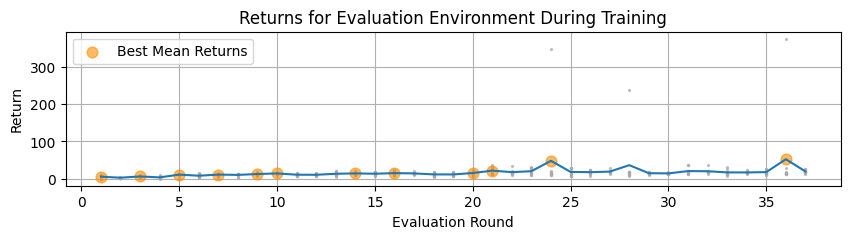

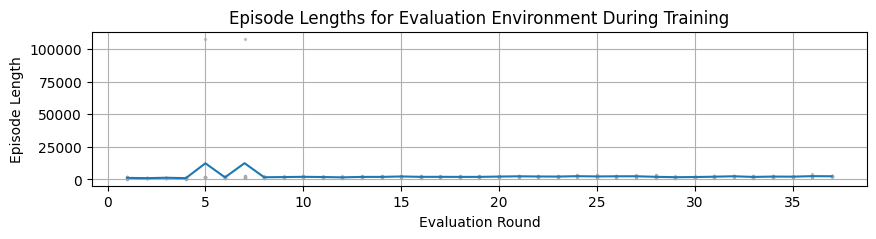

In [ ]:
sb3_evaluation_curves(path = 'breakout_evaluation/')

## 2.E - Load and Evaluate the Best Model

Use the cell below to load the best model encountered during training. Set `env` equal to your framestacked test environment when calling `PPO.load()`. Create an instance of `SB3Agent` using the loaded model. Then use the `evaluate()` function to score the agent on the test environment, setting `gamma=1.0`, `episodes=10`, `max_steps=2000`, and `seed=1`.


In [ ]:
breakout_best = PPO.load(path = 'breakout_evaluation/best_model.zip', env = breakout_test_vec_env)

breakout_sb3 = SB3Agent(breakout_best)

breakout_eval = evaluate(env = breakout_test_vec_env,
                         agent = breakout_sb3,
                         gamma = 1.0,
                         episodes = 10,
                         max_steps = 2_000,
                         seed = 1
                         )

Mean Return:    16.4
StdDev Return:  2.498
Mean Length:    536.5
StdDev Length:  120.0577


### Extra Credit Opportunity

If you trained the model using the parameters provided in 2.C and used a T4 GPU for training, the cell above should result in a mean return of approximately 20 and a standard deviation of about 0.5. If you would like, you can adjust the parameters in 2.C to see if you can train a model with better performance. If you can train a model for which `Mean[Return] - StdDev[Return] > 20`, you will earn some extra credit on this assignment. The amount of extra credit will depend on by how much your model exceeds the goal of 20.

If you wish to try to obtain a better score, I recommend focusing on the values for the learning rate, the number of time steps, and perhaps the clip range. You can experiment with any of the parameters, however.

Keep in mind that if you change the parameters in 2C, you should re-run the cells in 2A and 2B (or restart your kernel).

**If you do find parameters that produce better performance, do not share these with other students! Two students submitting the exact same parameter values will be subject to scrutiny.**


## 2.F - Sample Episode For PPO Agent

Use the cell below to create gif demonstrating an episode generated by the PPO agent. Set `max_steps=2000`, `seed=1`, and `scale=1.5` when calling `create_gif()`.


602 steps completed.
Cumulative reward: 18.0


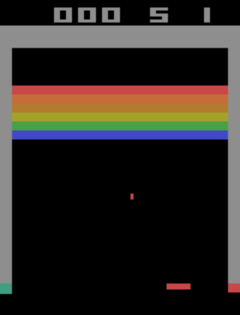

In [ ]:
create_gif(env = breakout_test_vec_env,
           agent = breakout_sb3,
           max_steps = 2_000,
           seed = 1,
           scale = 1.5,
           folder = 'gifs',
           filename = 'breakout_ppo'
           )

# Part 3 - Pretrained Model

In Part 3, you will load and evaluated a PPO model that has previously been trained for 5 million time steps (and several hours) on the Breakout environment. This is to provide you with a sense as to what is possible if we allowed the model to train longer.


## 3.A - Load and Evaluated the Model

The model for Part 3 is stored in the following file on the VM for your notebook:

`/content/rl_models/breakout/breakout_ppo_final.zip`

Use the cell below to load this model. Set `env` equal to your framestacked test environment when calling `PPO.load()`. Create an instance of `SB3Agent` using the loaded model. Then use the `evaluate()` function to score the agent on the test environment, setting `gamma=1.0`, `episodes=10`, `max_steps=2000`, and `seed=1`.


In [ ]:
breakout_final = PPO.load(path = '/content/rl_models/breakout/breakout_ppo_final.zip', env = breakout_test_vec_env)

breakout_final_sb3 = SB3Agent(breakout_final)

breakout_final_eval = evaluate(env = breakout_test_vec_env,
                               agent = breakout_final_sb3,
                               gamma = 1.0,
                               episodes = 10,
                               max_steps = 2_000,
                               seed = 1
                               )

Wrapping the env in a VecTransposeImage.
Mean Return:    364.0
StdDev Return:  42.0666
Mean Length:    2000.0
StdDev Length:  0.0


## 3.B - Sample Episode For Pretrained PPO Agent

Use the cell below to create gif demonstrating an episode generated by the pretrained PPO agent. Set `max_steps=2000`, `seed=1`, and `scale=1.5` when calling `create_gif()`.

**Note** This model would be able to continuing playing for longer than 2000 timesteps. We are cutting the episode off early for the sake of time, however.

2000 steps completed.
Cumulative reward: 394.0


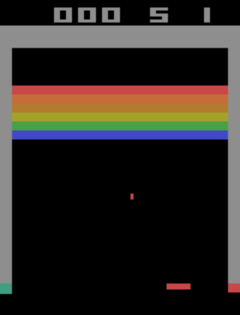

In [ ]:
create_gif(env = breakout_test_vec_env,
           agent = breakout_final_sb3,
           max_steps = 2_000,
           seed = 1,
           scale = 1.5,
           folder = 'gifs',
           filename = 'breakout_final'
           )

# Submission Instructions

1. The cell below will generate an HTML render of your notebook within the same Google Drive folder in which you stored this notebook. Adjust the path for your notebook in the cell below as needed.
2. Restart your notebook and run it from start to finish.
3. If the notebook executes without error, download the HTML export of the notebook and then upload it to Canvas. Make sure to carefully review the contents of the HTML export to ensure that everything is displayed correctly.
4. Click on "Share" in the upper-right corner of this notebook. Then select "Anyone with the link" from dropdown. Click "Copy Link" and paste the copied link as a comment in your submission on Canvas.


In [ ]:
%%capture
import time
time.sleep(30)
!jupyter nbconvert --to html /content/drive/MyDrive/COSC_635/Lab_08_zziauddin1.ipynb